In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd

## Funciones auxiliares

In [24]:
#funcion para procesar las series y verificar los valores nulos 
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isna().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

## Procesing data

In [58]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [59]:
building_11a=building_11a.resample("h").sum()

In [60]:
#realizamos una lista de arrays cada array correspondiendo a 1 dia de datos con frecuencia de muestreo por 15 minutos
# Agrupar por día
df=building_11a.copy()
# Agrupar por día y guardar los DataFrames en una lista
list_of_dataframes = [group for _, group in df.groupby(df.index.date)]

# Imprimir el resultado
for i, daily_df in enumerate(list_of_dataframes):
    print(f"Día {i+1}:")
    print(daily_df)
    print("-" * 50)


Día 1:
                             kwh
timestamp                       
2023-01-01 00:00:00+00:00  54.90
2023-01-01 01:00:00+00:00  53.81
2023-01-01 02:00:00+00:00  52.92
2023-01-01 03:00:00+00:00  55.99
2023-01-01 04:00:00+00:00  57.55
2023-01-01 05:00:00+00:00  53.89
2023-01-01 06:00:00+00:00  52.87
2023-01-01 07:00:00+00:00  46.73
2023-01-01 08:00:00+00:00  51.08
2023-01-01 09:00:00+00:00  55.15
2023-01-01 10:00:00+00:00  51.41
2023-01-01 11:00:00+00:00  57.62
2023-01-01 12:00:00+00:00  56.59
2023-01-01 13:00:00+00:00  59.29
2023-01-01 14:00:00+00:00  61.22
2023-01-01 15:00:00+00:00  60.16
2023-01-01 16:00:00+00:00  57.73
2023-01-01 17:00:00+00:00  59.19
2023-01-01 18:00:00+00:00  61.27
2023-01-01 19:00:00+00:00  65.10
2023-01-01 20:00:00+00:00  57.67
2023-01-01 21:00:00+00:00  58.05
2023-01-01 22:00:00+00:00  59.79
2023-01-01 23:00:00+00:00  60.30
--------------------------------------------------
Día 2:
                             kwh
timestamp                       
2023-01-02 

In [61]:
nan_counter(list_of_dataframes)

0


In [62]:
len(list_of_dataframes)

365

<Axes: xlabel='timestamp'>

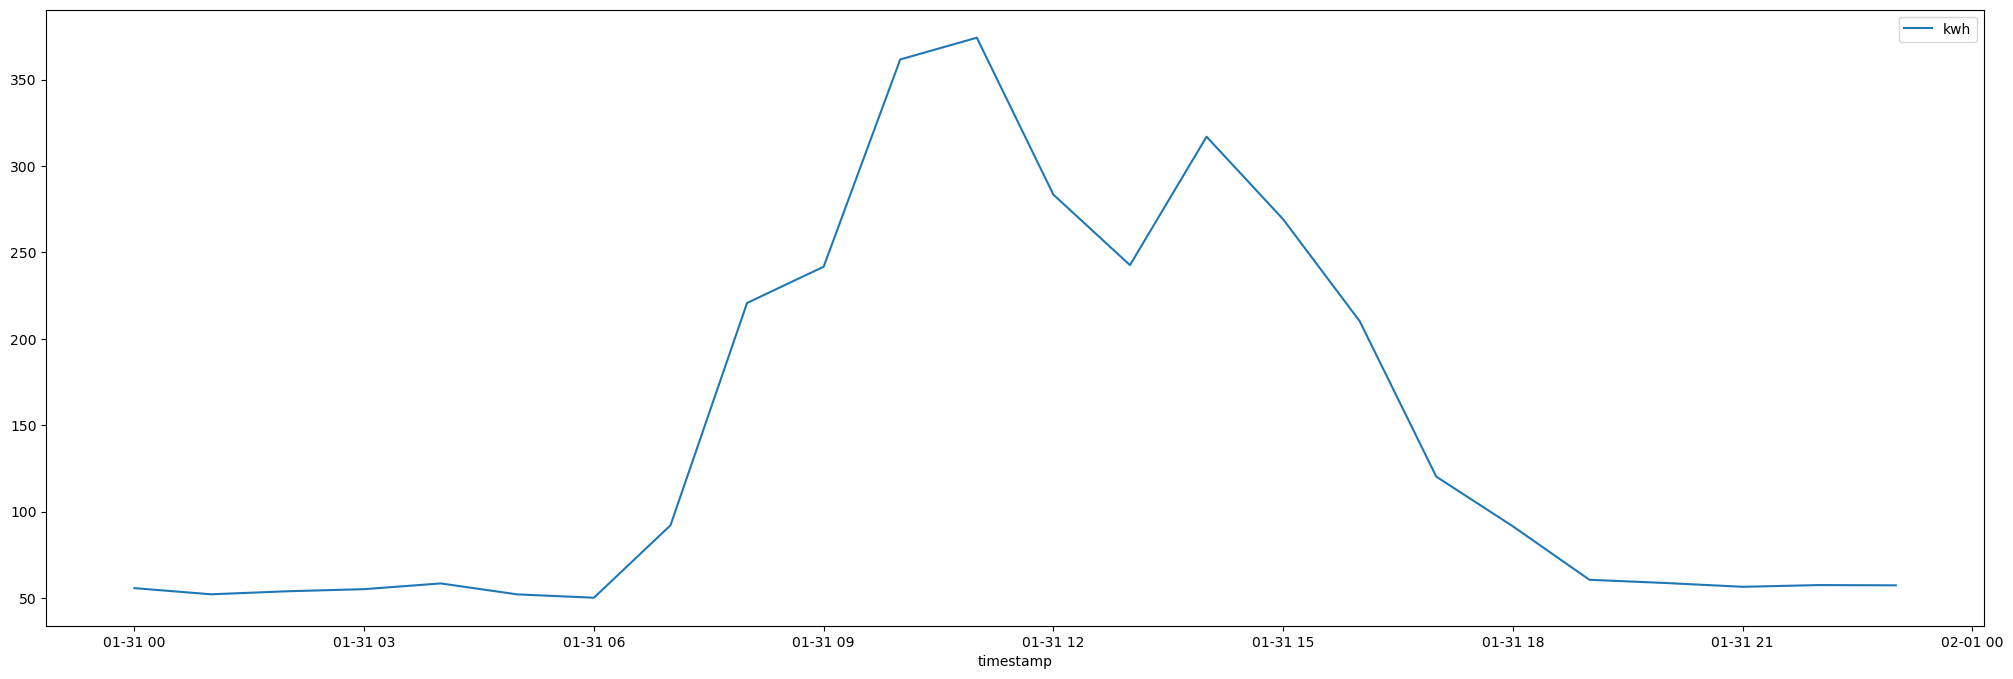

In [63]:
sns.lineplot(list_of_dataframes[30])

## clustering

Después de gestionar los valores faltantes, el otro problema es la escala de la serie. Sin la normalización de los datos, las series que se parecen entre sí se verán muy diferentes entre sí y afectarán la precisión del proceso de agrupamiento. Podemos ver el efecto de la normalización en las siguientes imágenes.

In [64]:
for i in range(len(list_of_dataframes)):
    scaler = MinMaxScaler()
    list_of_dataframes[i] = MinMaxScaler().fit_transform(list_of_dataframes[i])
    list_of_dataframes[i]= list_of_dataframes[i].reshape(len(list_of_dataframes[i]))

El resultado del proceso de normalización parece bueno.

In [65]:
print("max: "+str(max(list_of_dataframes[0]))+"\tmin: "+str(min(list_of_dataframes[0])))
print(list_of_dataframes[0][:5])

max: 1.0	min: 0.0
[0.44474687 0.385411   0.33696244 0.50408274 0.58900381]


## kmeans

In [66]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    km = km.fit(list_of_dataframes)
    Sum_of_squared_distances.append(km.inertia_)

c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\li

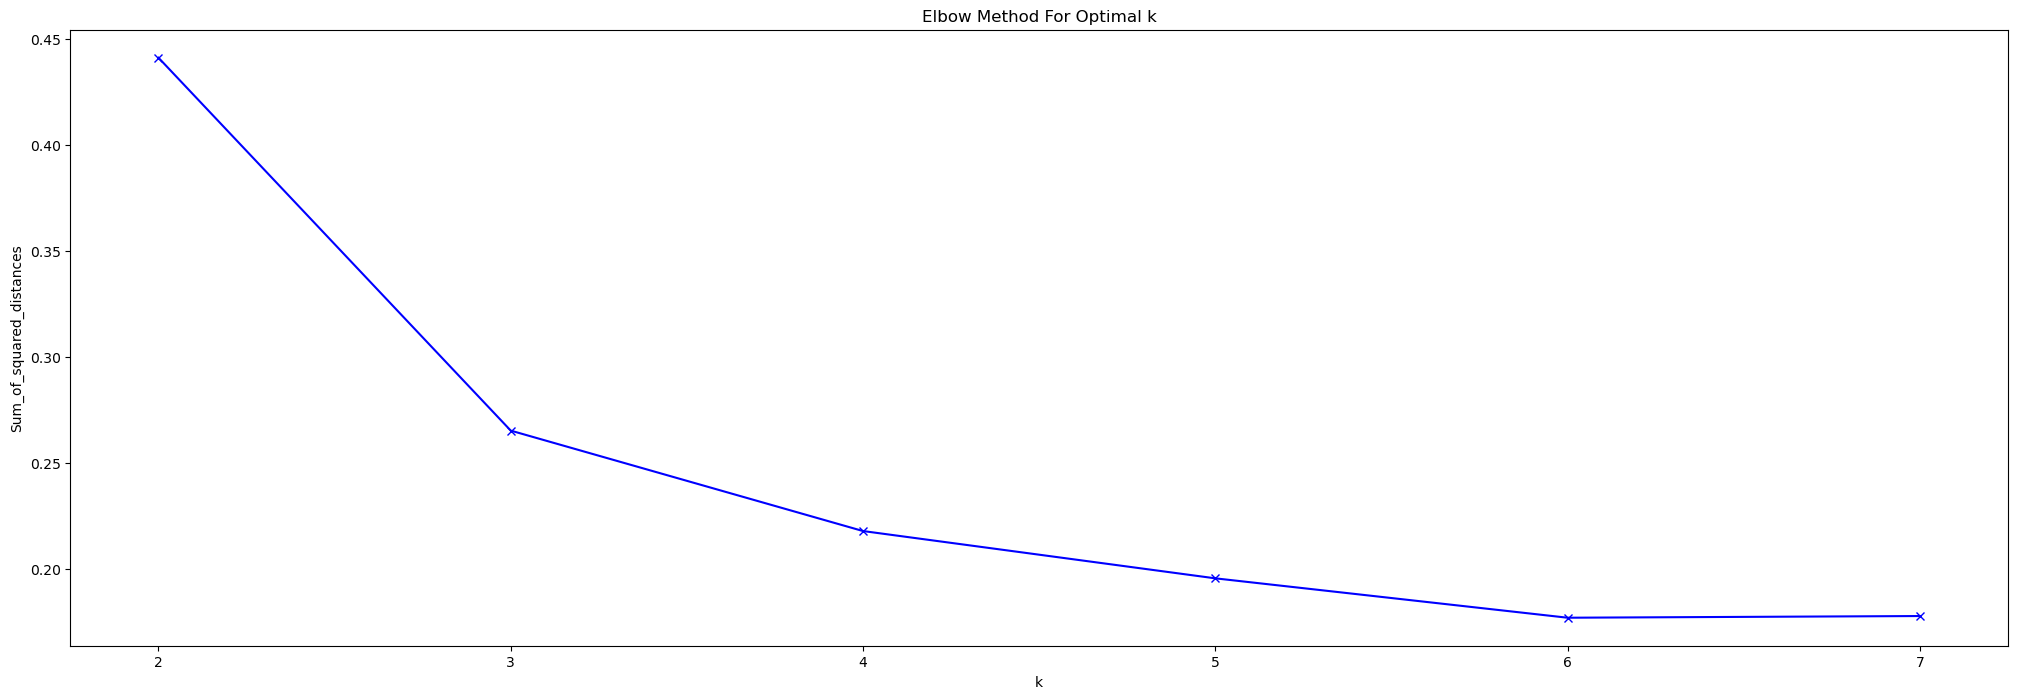

In [67]:
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [68]:
Sum_of_squared_distances

[np.float64(0.44130106822624143),
 np.float64(0.2654060092499969),
 np.float64(0.21803211406482984),
 np.float64(0.19572773501533122),
 np.float64(0.17714936074504653),
 np.float64(0.17794310812958056)]

## Training  kmeans 

usando distancia Euclidiana

In [73]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")

labels = km.fit_predict(list_of_dataframes)

c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


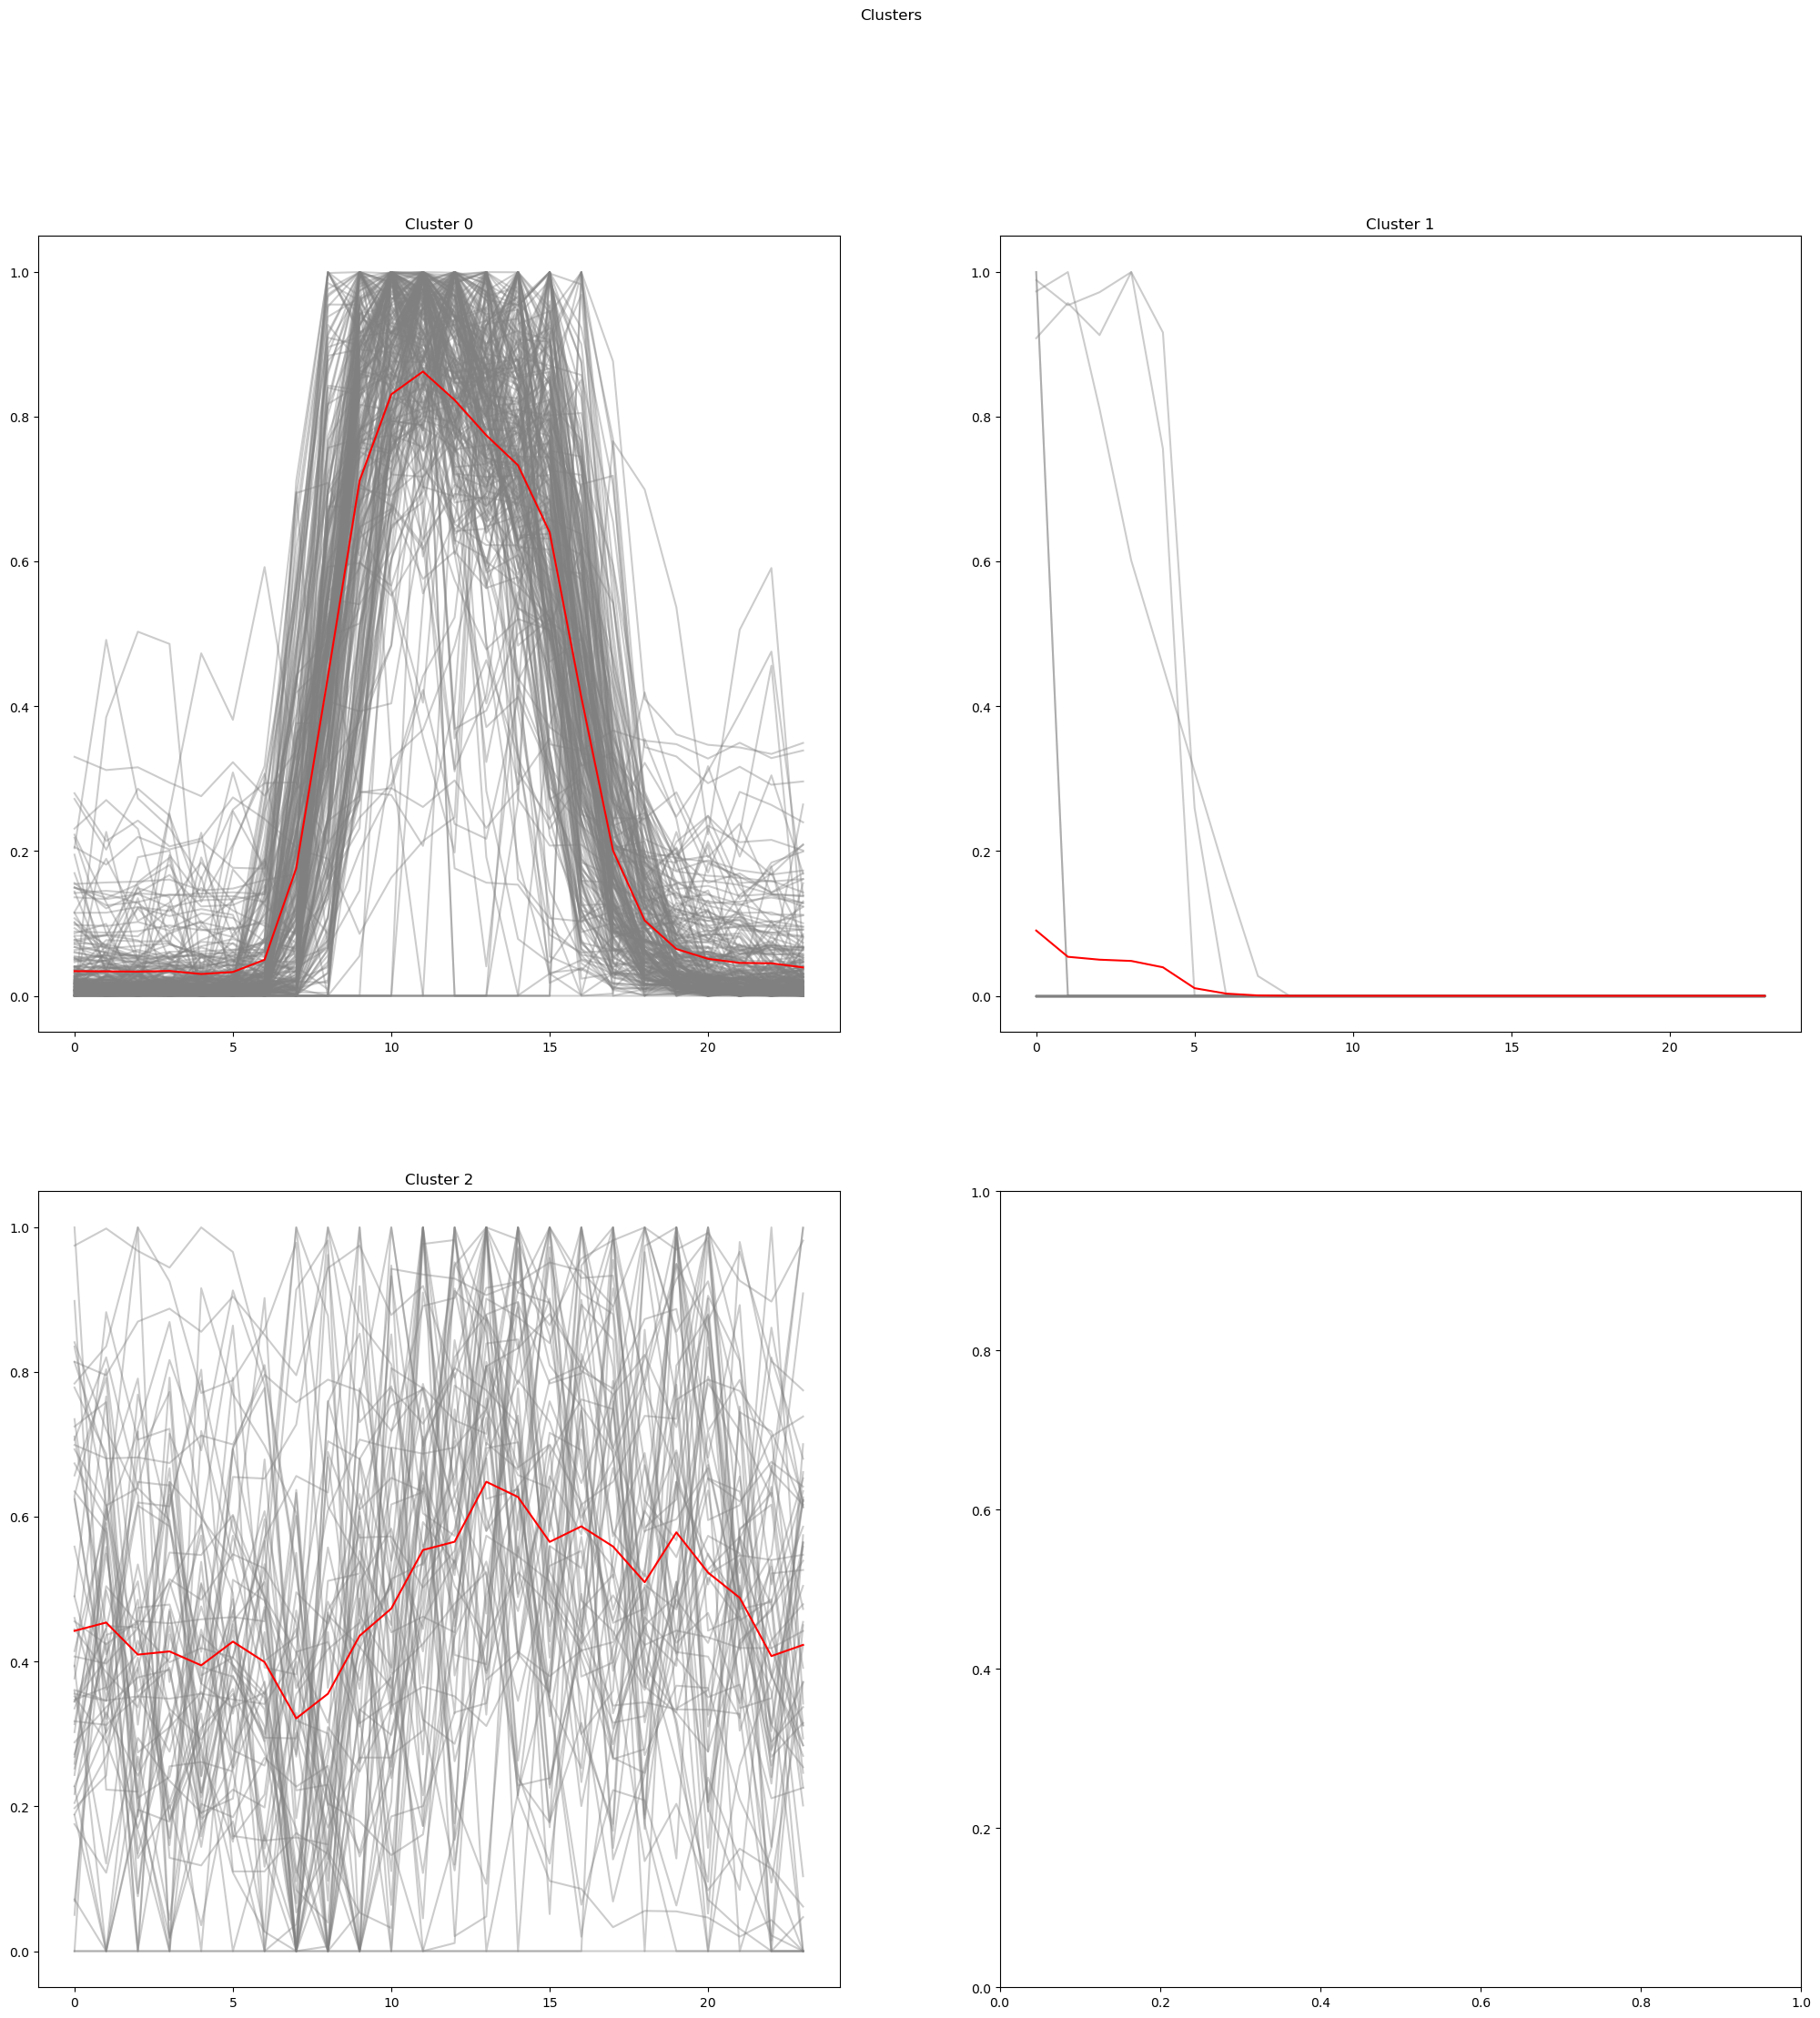

In [79]:
import math
plot_count = math.ceil(math.sqrt(3))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(list_of_dataframes[i],c="gray",alpha=0.4)
                cluster.append(list_of_dataframes[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*labels[i]+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

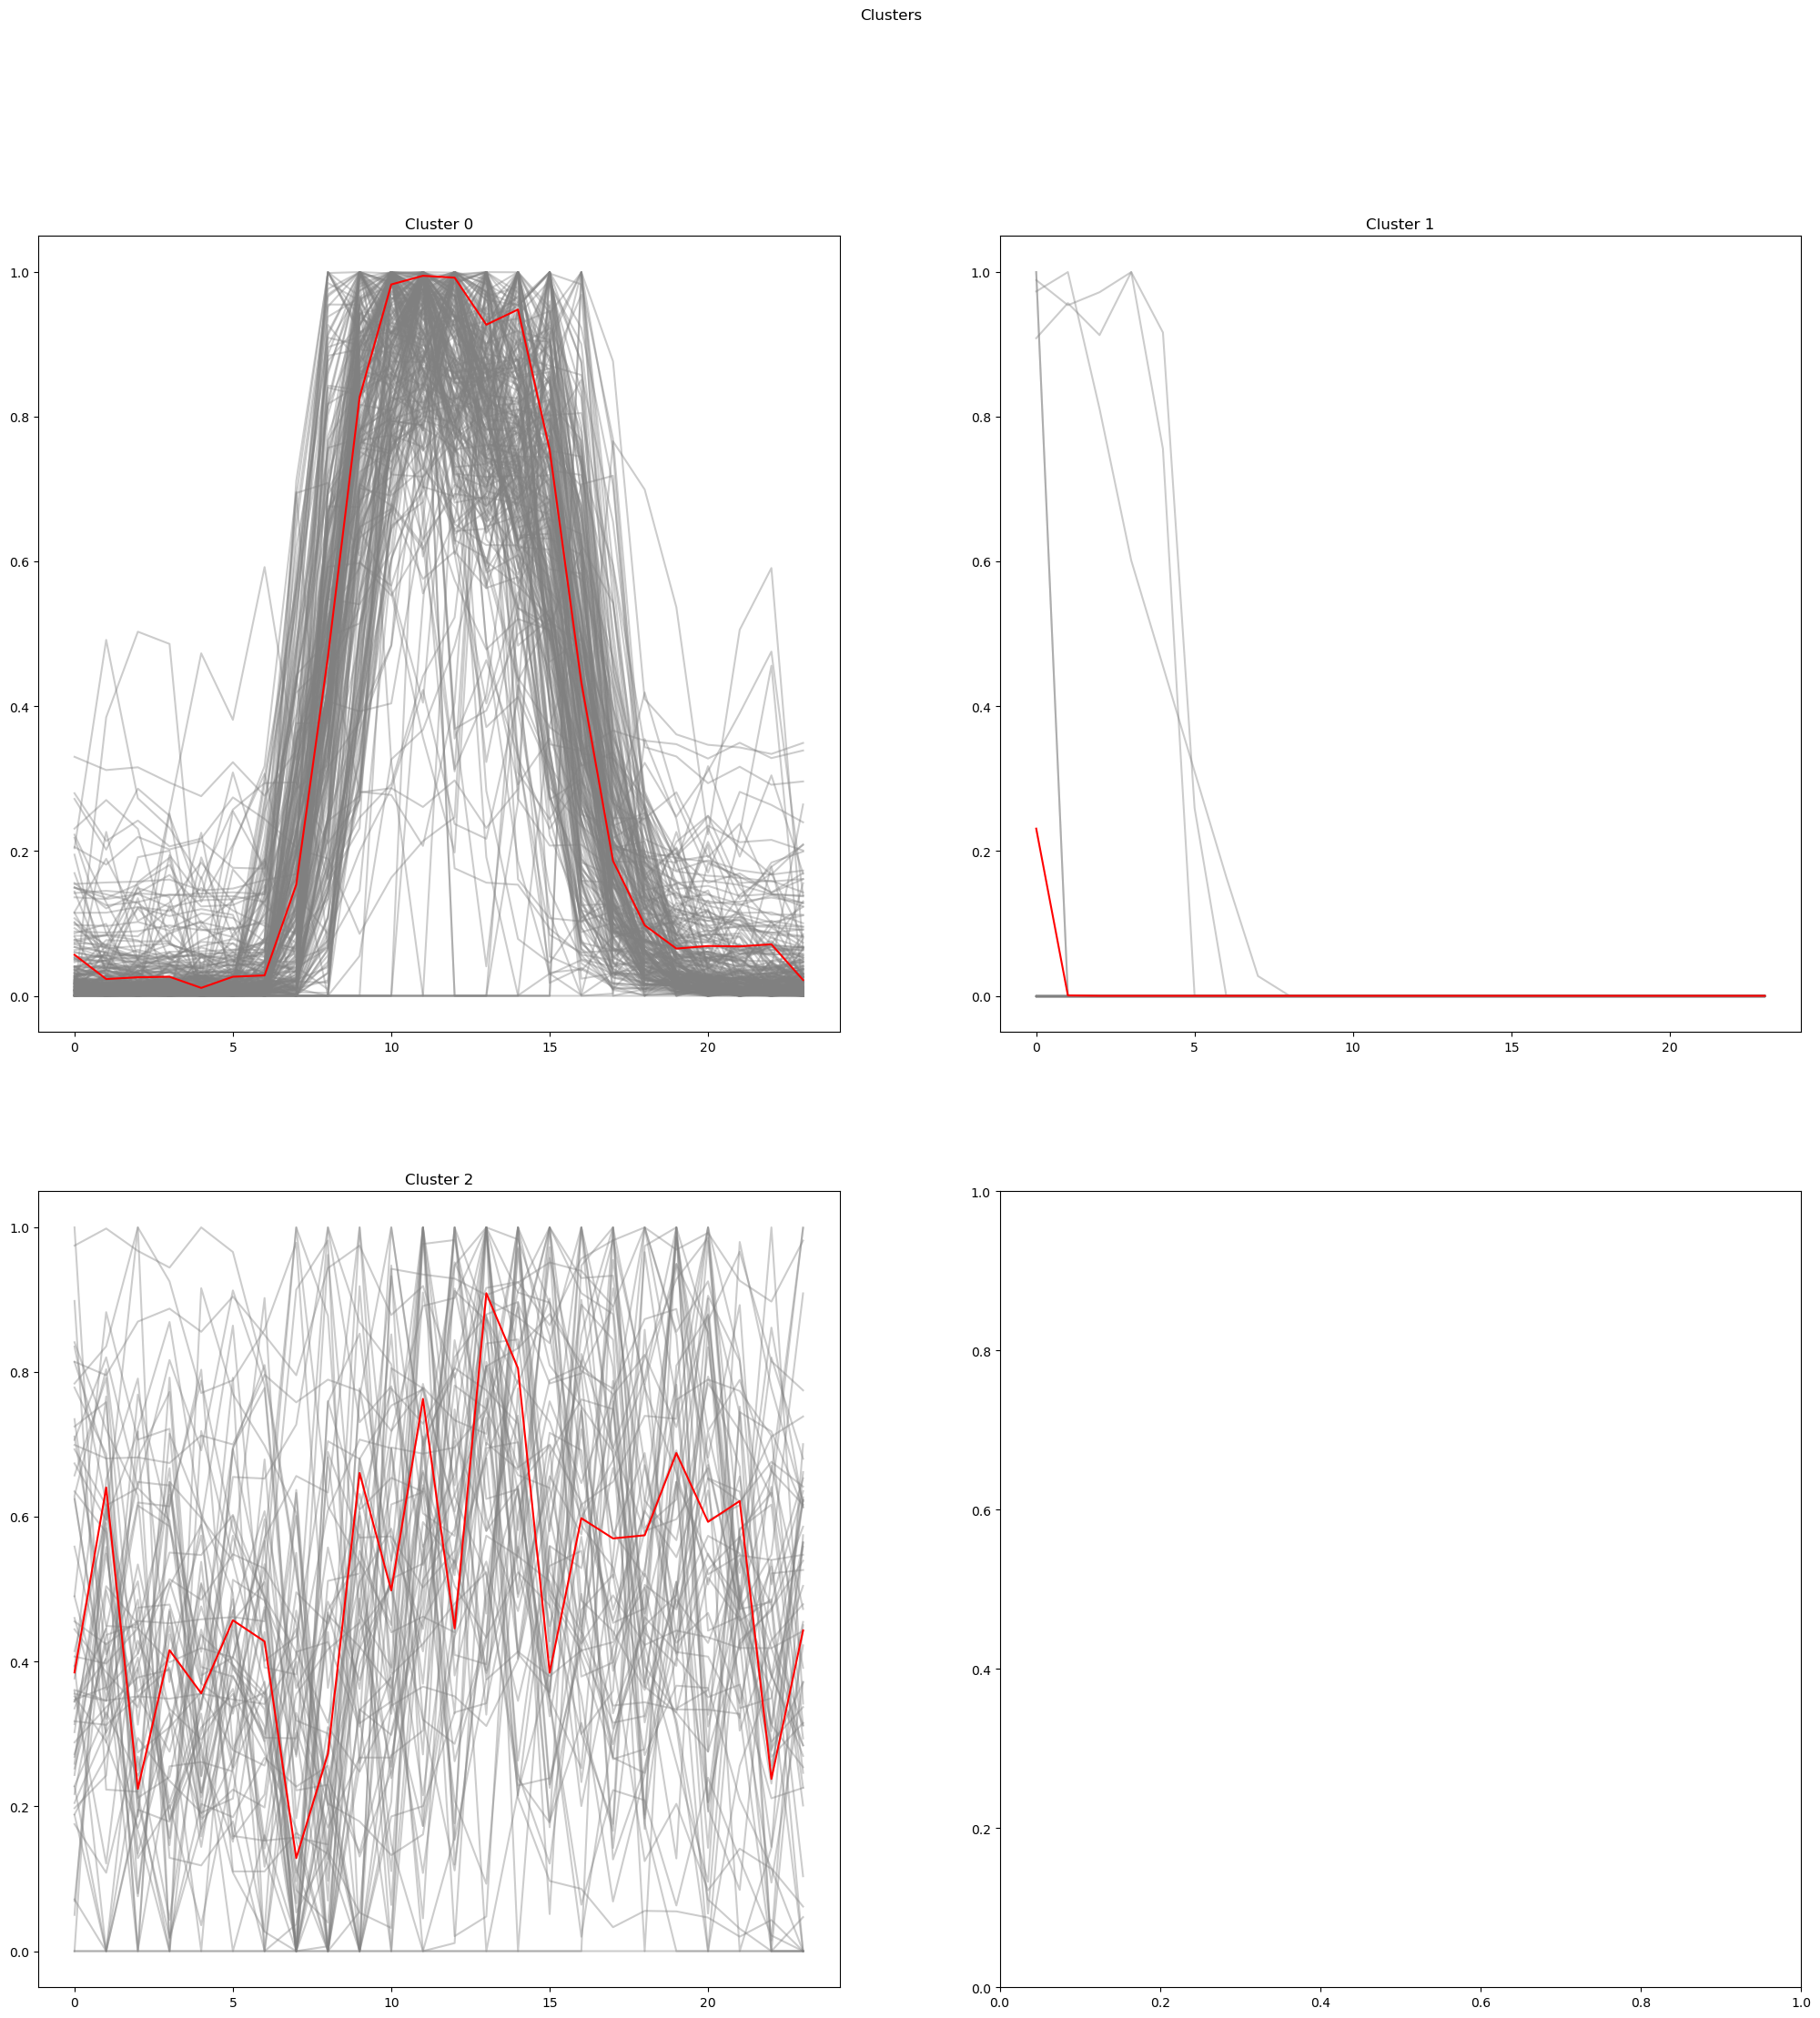

In [78]:
from tslearn.barycenters import dtw_barycenter_averaging

plot_count = math.ceil(math.sqrt(3))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(list_of_dataframes[i],c="gray",alpha=0.4)
                cluster.append(list_of_dataframes[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*labels[i]+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

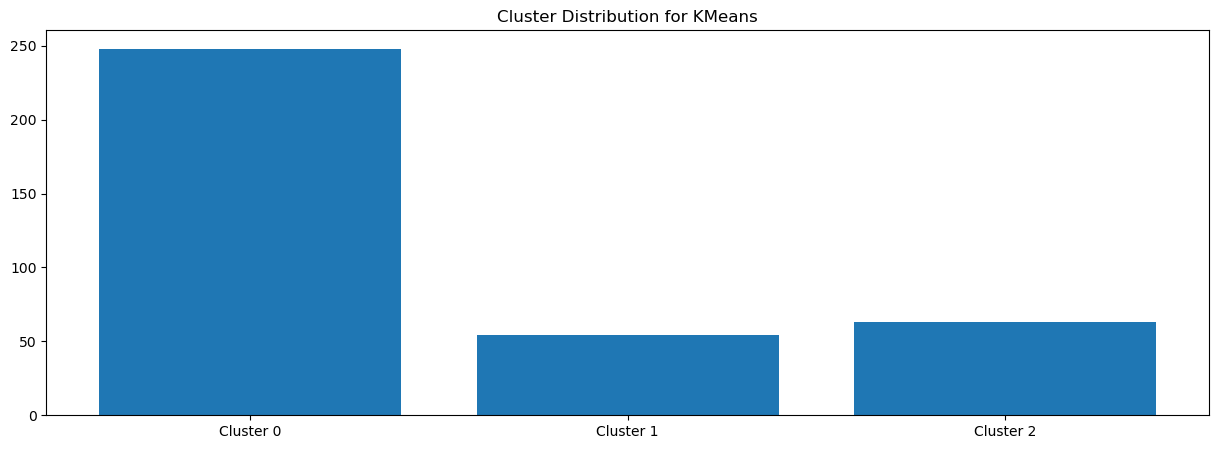

In [77]:
cluster_c = [len(labels[labels==i]) for i in range(3)]
cluster_n = ["Cluster "+str(i) for i in range(3)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()